# Diagrams for the second paper

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern math fonts
mpl.rcParams['font.family'] = 'STIXGeneral'  # Use STIX fonts (similar to Computer Modern)
plt.rcParams.update({'font.size': 18})

cs = {"y":'#ffb000',
      "o":'#fe6100',
      "m":'#dc267f',
      "p":'#785ef0',
      "b":'#648fff'}

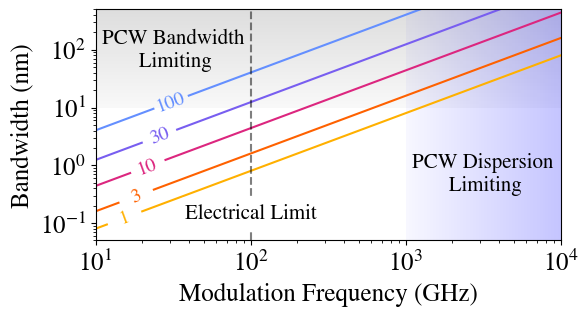

In [2]:
fig = plt.figure(figsize=(6,3))
xs = np.logspace(1,4,1000)

s,e = 25,100

for i,c in zip([1,3,10,30,100],cs.values()):
    mid = (s+e)//2
    ys = 0.5 * xs * (i + 1) * (1550E-9) ** 2 / (const.c) * 1E9 * 1E9
    # Plot the main line
    plt.plot(xs[:s], ys[:s], color=c)
    plt.plot(xs[e:], ys[e:], color=c)

    plt.text(xs[mid], ys[mid], f'{i}', color=c, ha='center', va='center', fontsize=14, rotation=20)  # Adjust rotation angle as desired
    s += 25
    e += 25

# Add shaded regions
# Create a faded horizontal gradient region
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Faded horizontal shaded region: y in [10,1e3]
ymin, ymax = 10, 1e3
nsteps = 200
ys = np.logspace(np.log10(ymin), np.log10(ymax), nsteps)
for i in range(nsteps - 1):
    alpha = 0.05 + 0.25 * (i / (nsteps - 1))  # Fades in as y increases
    plt.fill_between([plt.xlim()[0], plt.xlim()[1]], ys[i], ys[i+1], 
                     color='gray', alpha=alpha, edgecolor=None)

# Faded vertical shaded region: x in [1000,10000]
xmin, xmax = 1000, 10000
nsteps = 200
xs = np.logspace(np.log10(xmin), np.log10(xmax), nsteps)
for i in range(nsteps - 1):
    alpha = 0.03 + 0.20 * (i / (nsteps - 1))  # Fades in as x increases
    plt.fill_betweenx([plt.ylim()[0], plt.ylim()[1]], xs[i], xs[i+1], 
                      color='blue', alpha=alpha, edgecolor=None)

#add vertical line 
plt.axvline(100, color='k', linestyle='--', alpha=0.5)

#add labels of different regions 
plt.text(100, 1e-1, 'Electrical Limit', color='k', ha='center', va='bottom', fontsize=15,bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.25'))
plt.text(11, 1e2, 'PCW Bandwidth\n       Limiting', color='k', ha='left', va='center', fontsize=15)
plt.text(1100, .3, 'PCW Dispersion\n       Limiting', color='k', ha='left', va='bottom', fontsize=15)

#set limits 
plt.xlim(10,10000)
plt.ylim(5e-2,5e2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Modulation Frequency (GHz)')
plt.ylabel('Bandwidth (nm)')


plt.show()

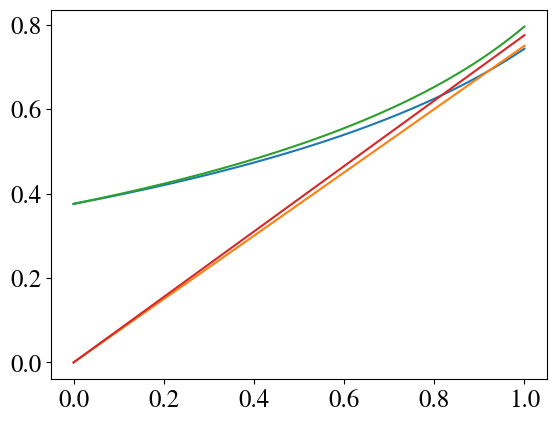

In [2]:
LossLim = 5
EL = 3

#fucntion to get the phase shift allowable by loss limits
phi = lambda alpha,ng,L: np.arccos(10**(np.log10(2)-(LossLim-ng**2*alpha*L)/10)-1)

#function to get the phase induced by the given length
def dphi(alpha,ng,L):
    phis = phi(alpha,ng,L)
    expon = -EL/10+np.log10(1+np.cos(phis))
    return np.arccos(10**expon-1)-phis

#the phase shift that is caused by the given length
def dphi_L(dnng,L):
    return 1250*L*dnng

ls = np.linspace(0,1,1000)
alphas = 0.004
ngs = 30
dns = 2e-5
dnng = dns*ngs

plt.plot(ls,dphi(alphas,ngs,ls))
plt.plot(ls,dphi_L(dnng,ls))
plt.plot(ls,dphi(alphas,ngs+1,ls))
plt.plot(ls,dphi_L(dns*(ngs+1),ls))
plt.show()

In [6]:
from scipy.optimize import root_scalar

# Parameter ranges
alpha_min, alpha_max = 0.0005, 0.5
dn_min, dn_max = 5e-6, 5e-4  # Range for dn (will be converted to dnng = dn * ng)

# Grid resolution
n_alpha = 50
n_dn = 50

# Create grids
alpha_grid = np.logspace(np.log10(alpha_min), np.log10(alpha_max), n_alpha)
dn_grid = np.logspace(np.log10(dn_min), np.log10(dn_max), n_dn)

# Specify L values for contour lines
L_levels = [0.25, 0.4, 0.6, 0.8, 1]  # Modify this list to specify desired L values

# ng values to compute
ng_values = [10, 20, 30]

# Dictionary to store contour data: {ng: {L_value: {'x': [...], 'y': [...]}}}
contour_data = {}

# Function to find intersection
def find_intersection(alpha, dnng, ng, L_max=4):
    """
    Find the smallest L > 0 where dphi(alpha, ng, L) = dphi_L(dnng, L)
    """
    def diff_func(L):
        try:
            val = dphi(alpha, ng, L) - dphi_L(dnng, L)
            if np.isnan(val) or np.isinf(val):
                return 1e10  # Return large value for invalid cases
            return val
        except (ValueError, ArithmeticError):
            # Handle domain errors (e.g., arccos argument out of range)
            return 1e10  # Return large value instead of NaN
    
    # Try to find root in [0, L_max]
    # First check if there's a sign change
    try:
        L_test = np.linspace(1e-6, L_max, 1000)
        diffs = []
        for L in L_test:
            diff_val = diff_func(L)
            diffs.append(diff_val)
        diffs = np.array(diffs)
        
        # Filter out invalid values (very large) and find sign changes
        valid_mask = np.abs(diffs) < 1e9
        if not np.any(valid_mask):
            return np.nan
        
        # Find where the difference changes sign among valid values
        valid_diffs = diffs[valid_mask]
        valid_L = L_test[valid_mask]
        sign_changes = np.where(np.diff(np.sign(valid_diffs)) != 0)[0]
        
        if len(sign_changes) > 0:
            # Find the smallest intersection
            for idx in sign_changes:
                L_low = valid_L[idx]
                L_high = valid_L[idx + 1]
                # Verify the bracket has opposite signs
                if diff_func(L_low) * diff_func(L_high) < 0:
                    try:
                        result = root_scalar(diff_func, bracket=[L_low, L_high], method='brentq')
                        if result.converged and result.root > 0:
                            return result.root
                    except (ValueError, RuntimeError):
                        continue
    except:
        pass
    
    return np.nan

# Loop over ng values
for ng in ng_values:
    print(f"\nComputing for ng = {ng}...")
    contour_data[ng] = {}
    
    # Initialize result array
    L_intersection = np.full((n_alpha, n_dn), np.nan)
    
    # Compute intersections for each grid point
    for i, alpha in enumerate(alpha_grid):
        if i % 10 == 0:
            print(f"  Progress: {i}/{n_alpha}")
        for j, dn in enumerate(dn_grid):
            dnng = dn * ng  # Convert dn to dnng
            L_intersection[i, j] = find_intersection(alpha, dnng, ng)
    
    # Create meshgrid (using dn for x-axis)
    X, Y = np.meshgrid(dn_grid, alpha_grid)
    
    # Mask NaN values for contour plotting
    L_contour = np.ma.masked_invalid(L_intersection)
    
    # Create contour lines with specified L levels
    contours = plt.contour(X, Y, L_contour, levels=L_levels)
    
    # Extract contour line coordinates
    # contours.allsegs is a list of lists, one per level
    # Each inner list contains arrays of (x, y) coordinates for each contour segment
    for level_idx, level in enumerate(L_levels):
        contour_data[ng][level] = {'x': [], 'y': []}
        
        # Get segments for this level
        if level_idx < len(contours.allsegs):
            segments = contours.allsegs[level_idx]
            for segment in segments:
                if len(segment) > 0:
                    # segment is an array of shape (n_points, 2) with [x, y] coordinates
                    x_coords = segment[:, 0]  # dn values
                    y_coords = segment[:, 1]  # alpha values
                    
                    # Store coordinates
                    contour_data[ng][level]['x'].append(x_coords)
                    contour_data[ng][level]['y'].append(y_coords)
    
    # Close the figure to avoid displaying it
    plt.close()

print("\nContour data saved in 'contour_data' dictionary")
print("Structure: contour_data[ng][L_value]['x'] and contour_data[ng][L_value]['y']")
print("Each 'x' and 'y' entry is a list of arrays (one array per contour segment)")


Computing for ng = 10...
  Progress: 0/50
  Progress: 10/50
  Progress: 20/50


/var/folders/hw/03zfk07n30vg93xfdj4v1t5w0000gp/T/ipykernel_19932/2397973831.py:5: RuntimeWarning: invalid value encountered in arccos
  phi = lambda alpha,ng,L: np.arccos(10**(np.log10(2)-(LossLim-ng**2*alpha*L)/10)-1)


  Progress: 30/50
  Progress: 40/50

Computing for ng = 20...
  Progress: 0/50
  Progress: 10/50
  Progress: 20/50
  Progress: 30/50
  Progress: 40/50

Computing for ng = 30...
  Progress: 0/50
  Progress: 10/50
  Progress: 20/50
  Progress: 30/50
  Progress: 40/50

Contour data saved in 'contour_data' dictionary
Structure: contour_data[ng][L_value]['x'] and contour_data[ng][L_value]['y']
Each 'x' and 'y' entry is a list of arrays (one array per contour segment)


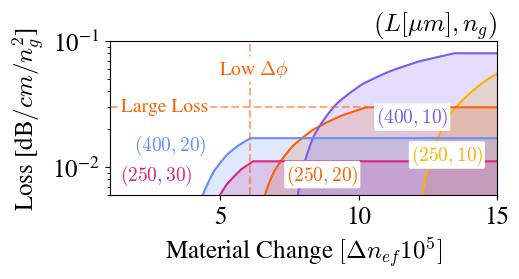

In [76]:
fig = plt.figure(figsize=(5,2))
Ings = [10,20,30,10,20,30]
ILs = [0.25,0.25,0.25,0.4,0.4]

for ing, il, c in zip(Ings, ILs, cs.values()):
    x = np.hstack(contour_data[ing][il]['x'])*1e5
    y = np.hstack(contour_data[ing][il]['y'])
    x = np.hstack([x,30])
    y = np.hstack([y,y[-1]])
    plt.plot(x, y, color=c)
    plt.fill_between(x, y, y2=0, color=c, alpha=0.2)


#add axis labels 
plt.xlabel(r'Material Change $[\Delta n_{ef}10^5]$')
plt.ylabel(r'Loss [dB$/cm/n_g^2$]')

#add labels 
plt.text(15,0.1,r'$\left(L [\mu m],n_g\right)$',color='k',va='bottom',ha='right')
plt.text(14.5,0.01,r'$(250,10)$',color=cs['y'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
plt.text(10,0.007,r'$(250,20)$',color=cs['o'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
plt.text(4,0.007,r'$(250,30)$',color=cs['m'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
plt.text(13.25,0.02,r'$(400,10)$',color=cs['p'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
plt.text(4.5,0.012,r'$(400,20)$',color=cs['b'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)

#add limit lines
plt.axvline(np.min(np.hstack(contour_data[20][0.25]['x']))*1e5,color=cs['o'],linestyle='--',alpha=0.5)
plt.plot([1,contour_data[20][0.25]['x'][-1][-1]*1e5],[contour_data[20][0.25]['y'][-1][-1]]*2,color=cs['o'],linestyle='--',alpha=0.5)

#add limit line lables
plt.text(3,0.03,r'Large Loss',color=cs['o'],va='center',ha='center',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
plt.text(6.2,0.06,r'Low $\Delta \phi$',color=cs['o'],va='center',ha='center',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)

plt.yscale('log')
plt.xlim(1,15)
plt.ylim(0.006,0.1)
plt.show()

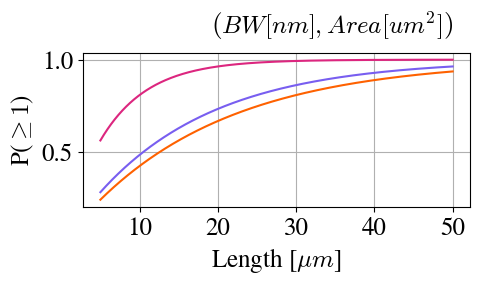

In [130]:
fig = plt.figure(figsize=(5,2))

#set spectral and spacial density
sdens = 1/100 #1/nm can be approximated with 1/sigma
pdens = 22 #1/um^2

#set the positional and spectral areas in um^2/a and nm
sodds = [10,30,30] #nm of bandwidth
podds = [.025,.025,.01] #1/um^2 of spacial area 

L = np.linspace(5,50,1000)

for isodd, ipodd, c in zip(sodds, podds, list(cs.values())[1:]):
    y = 1-np.e**(-isodd*ipodd*L*sdens*pdens)
    plt.plot(L, y, color=c)


#add axis labels 
plt.ylabel(r'P($\geq 1$)')
plt.xlabel(r'Length [$\mu m$]')

# #add labels 
plt.text(50,1.1,r'$\left(BW [nm], Area [um^2]\right)$',color='k',va='bottom',ha='right')
#plt.text(4,0.007,r'$(250,30)$',color=cs['m'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
#plt.text(13.25,0.02,r'$(400,10)$',color=cs['p'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
#plt.text(4.5,0.012,r'$(400,20)$',color=cs['b'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)

# #add limit lines
# plt.axvline(np.min(np.hstack(contour_data[20][0.25]['x']))*1e5,color=cs['o'],linestyle='--',alpha=0.5)
# plt.plot([1,contour_data[20][0.25]['x'][-1][-1]*1e5],[contour_data[20][0.25]['y'][-1][-1]]*2,color=cs['o'],linestyle='--',alpha=0.5)

# #add limit line lables
# plt.text(3,0.03,r'Large Loss',color=cs['o'],va='center',ha='center',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
# plt.text(6.2,0.06,r'Low $\Delta \phi$',color=cs['o'],va='center',ha='center',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
plt.grid()
plt.show()

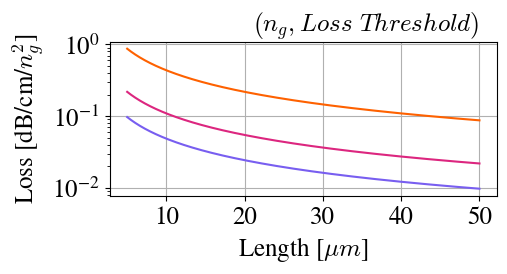

In [134]:
fig = plt.figure(figsize=(5,2))

#precent threshold and ng value 
ngs = [10,20,30]
thresholds = [0.99,0.99,0.99]

#different lengths
L = np.linspace(5,50,1000)



for ing, it, c in zip(ngs, thresholds, list(cs.values())[1:]):
    y = -10*np.log10(it)/(L*1e-4)/ing**2
    plt.plot(L, y, color=c)


#add axis labels 
plt.ylabel(r'Loss [dB/cm/$n_g^2$]')
plt.xlabel(r'Length [$\mu m$]')

# #add labels 
plt.text(50,1.1,r'$\left(n_g, Loss\ Threshold\right)$',color='k',va='bottom',ha='right')
# plt.text(14.5,0.01,r'$(250,10)$',color=cs['y'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
# plt.text(10,0.007,r'$(250,20)$',color=cs['o'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
# plt.text(4,0.007,r'$(250,30)$',color=cs['m'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
# plt.text(13.25,0.02,r'$(400,10)$',color=cs['p'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
# plt.text(4.5,0.012,r'$(400,20)$',color=cs['b'],va='bottom',ha='right',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)

# #add limit lines
# plt.axvline(np.min(np.hstack(contour_data[20][0.25]['x']))*1e5,color=cs['o'],linestyle='--',alpha=0.5)
# plt.plot([1,contour_data[20][0.25]['x'][-1][-1]*1e5],[contour_data[20][0.25]['y'][-1][-1]]*2,color=cs['o'],linestyle='--',alpha=0.5)

# #add limit line lables
# plt.text(3,0.03,r'Large Loss',color=cs['o'],va='center',ha='center',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
# plt.text(6.2,0.06,r'Low $\Delta \phi$',color=cs['o'],va='center',ha='center',bbox=dict(facecolor='w', edgecolor='w', boxstyle='round,pad=0.05'),fontsize=14)
plt.yscale('log')
plt.grid()
plt.show()

# Make the main first figure 

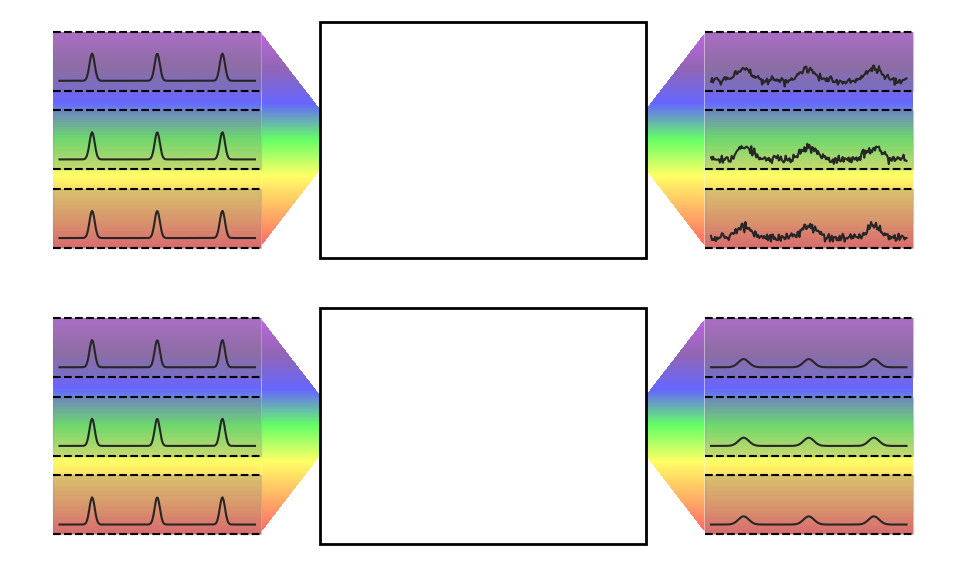

In [ ]:
# Diagram parameters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Layout parameters
container_width = 5
container_height = np.sqrt(3)/2*4
waveOffset = 1
container_x = 2.5
n_signals = 3
signal_spacing = container_height/3
channel_width = 0.75*container_height/3
container_y_bottom = 0
wave_length = 3
channel_buffer = 0.1
input_x = container_x - waveOffset - wave_length
output_x = container_x + container_width + waveOffset
x_wave = np.linspace(0, wave_length, 200)

# Wave pattern parameters - customize these to change the signal shapes
input_wave_params = {
    'n_peaks': 3,
    'amplitude': 0.4,
    'spread': 0.04,
    'phase_shift': lambda i: i * 0.1,
    'noise_level': 0
}

output_wave_params_top = {
    'n_peaks': 3,
    'amplitude': 0.18,
    'spread': 0.12,
    'phase_shift': lambda i: i * 0.1,
    'noise_level': 0.03
}

output_wave_params_bottom = {
    'n_peaks': 3,
    'amplitude': 0.12,
    'spread': 0.08,
    'phase_shift': lambda i: i * 0.1,
    'noise_level': 0
}

# Wave generation function
def generate_wave(x, params):
    """Generate wave pattern based on parameters"""
    wave = np.zeros_like(x)
    for i in range(params['n_peaks']):
        center = 0.5 + i * wave_length/params['n_peaks']
        gaussian = params['amplitude'] * np.exp(-((x - center) ** 2) / (2 * params['spread'] ** 2))
        wave += gaussian
    if params['noise_level'] > 0:
        wave += params['noise_level'] * np.random.normal(0, 1, len(x))
    return wave

# Channel drawing function
def draw_channel(ax, x_start, x_end, y_center, width, color='gray', alpha=0.3):
    """Draw a channel using only top/bottom dashed lines and semi-transparent shading inside"""

    # Get bottom and top y coordinates
    y_bottom = y_center
    y_top = y_center + width

    # Draw dashed top and bottom lines
    ax.plot([x_start, x_end], [y_bottom, y_bottom], linestyle='--', color='k', linewidth=1.5, alpha=1, zorder=4)
    ax.plot([x_start, x_end], [y_top, y_top], linestyle='--', color='k', linewidth=1.5, alpha=1, zorder=4)

    # Draw shading between top and bottom lines using fill_between
    ax.fill_between(
        [x_start, x_end],
        [y_top, y_top],
        [y_bottom, y_bottom],
        color=color,
        alpha=alpha,
        zorder=3
    )

# Function to draw rainbow trapezoid
def draw_rainbow_trapezoid(ax, x_start, x_end, y_top_start, y_bottom_start, y_top_end, y_bottom_end, n_steps=500):
    """Draw a trapezoid with rainbow gradient shading using imshow for artifact-free rendering"""
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.patches import PathPatch
    from matplotlib.path import Path
    import matplotlib.transforms as mtransforms
    
    # Calculate trapezoid dimensions
    y_range_start = y_top_start - y_bottom_start
    y_range_end = y_top_end - y_bottom_end
    
    # Create bounding box for the trapezoid (slightly larger to ensure full coverage)
    x_min = min(x_start, x_end)
    x_max = max(x_start, x_end)
    y_min = min(y_bottom_start, y_bottom_end)
    y_max = max(y_top_start, y_top_end)
    
    # Create a high-resolution grid
    ny = n_steps
    nx = max(50, int(ny * abs(x_end - x_start) / max(abs(y_range_start), abs(y_range_end))))
    
    # Create coordinate arrays
    y_coords = np.linspace(y_min, y_max, ny)
    x_coords = np.linspace(x_min, x_max, nx)
    Y, X = np.meshgrid(y_coords, x_coords, indexing='ij')
    
    # Create gradient data (vertical gradient from top to bottom)
    gradient = np.linspace(1, 0, ny).reshape(-1, 1)  # 1 at top (red), 0 at bottom (violet)
    gradient = np.tile(gradient, (1, nx))
    
    # Create mask for trapezoid shape using vectorized operations
    # Trapezoid has vertical sides at x_start and x_end
    # Top edge: (x_start, y_top_start) to (x_end, y_top_end)
    # Bottom edge: (x_start, y_bottom_start) to (x_end, y_bottom_end)
    
    # Check if x is within vertical boundaries
    x_in_bounds = (X >= min(x_start, x_end)) & (X <= max(x_start, x_end))
    
    # Calculate y boundaries at each x using linear interpolation
    if abs(x_end - x_start) > 1e-10:
        t_x = (X - x_start) / (x_end - x_start)
        y_top_at_x = y_top_start + t_x * (y_top_end - y_top_start)
        y_bottom_at_x = y_bottom_start + t_x * (y_bottom_end - y_bottom_start)
    else:
        y_top_at_x = np.full_like(X, min(y_top_start, y_top_end))
        y_bottom_at_x = np.full_like(X, max(y_bottom_start, y_bottom_end))
    
    # Check if y is within the trapezoid at each x
    y_min_at_x = np.minimum(y_top_at_x, y_bottom_at_x)
    y_max_at_x = np.maximum(y_top_at_x, y_bottom_at_x)
    y_in_bounds = (Y >= y_min_at_x) & (Y <= y_max_at_x)
    
    # Combine masks
    mask = x_in_bounds & y_in_bounds
    
    # Apply mask
    gradient[~mask] = np.nan
    
    # Use imshow for smooth rendering
    extent = [x_min, x_max, y_min, y_max]
    im = ax.imshow(gradient, cmap=cmap_, extent=extent, aspect='auto', 
                   origin='lower', alpha=0.6, zorder=2, interpolation='bilinear')
    
    # Clip to trapezoid shape using a path patch
    trapezoid_path = Path([
        [x_start, y_bottom_start],
        [x_start, y_top_start],
        [x_end, y_top_end],
        [x_end, y_bottom_end],
        [x_start, y_bottom_start]
    ])
    
    # Create clipping path
    clip_patch = PathPatch(trapezoid_path, transform=ax.transData)
    im.set_clip_path(clip_patch)

# Function to draw rainbow rectangle backdrop
def draw_rainbow_rectangle(ax, x_left, x_right, y_bottom, y_top, n_steps=100):
    """Draw a rectangle with rainbow gradient shading from top to bottom"""
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.patches import Rectangle
    
    # Create rainbow colormap
    colors = ['#9400D3', '#4B0082', '#0000FF', '#00FF00', '#FFFF00', '#FF7F00', '#FF0000']
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('rainbow', colors, N=n_bins)
    
    # Draw rectangle with gradient by creating many horizontal strips
    height = y_top - y_bottom
    width = x_right - x_left
    
    for i in range(n_steps):
        t = i / n_steps
        t_next = (i + 1) / n_steps
        
        # Calculate y positions for this strip
        y_bottom_strip = y_bottom + t * height
        y_top_strip = y_bottom + t_next * height
        strip_height = y_top_strip - y_bottom_strip
        
        # Get color from colormap (rainbow from top to bottom)
        # Map position to color: top (t=0) gets red, bottom (t=1) gets violet
        color = cmap(1 - t)
        
        rect = Rectangle((x_left, y_bottom_strip), width, strip_height,
                        facecolor=color, edgecolor='none', alpha=0.6, zorder=1.5)
        ax.add_patch(rect)

# Draw diagram function
def draw_diagram(ax, input_params, output_params):
    """Draw a single diagram with given wave parameters"""
    ax.axis('off')
    
    # Calculate channel positions
    channel_y_positions = []
    for i in range(n_signals):
        y_pos = container_y_bottom + 0.125*signal_spacing + i * signal_spacing
        channel_y_positions.append(y_pos)
    
    # Calculate top and bottom of channel region
    top_channel_top = channel_y_positions[-1] + channel_width
    bottom_channel_bottom = channel_y_positions[0]
    channel_region_height = top_channel_top - bottom_channel_bottom
    
    # Compression parameters for trapezoid
    compression_ratio = 0.3  # Box opening is 30% of channel region height
    box_opening_height = channel_region_height * compression_ratio
    box_opening_center = container_y_bottom + container_height / 2
    
    # Draw container first (background)
    rect = plt.Rectangle((container_x, container_y_bottom), container_width, container_height,
                        fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=3)
    ax.add_patch(rect)
    
    # Draw rainbow trapezoid from channels to box (input side) - behind channels
    draw_rainbow_trapezoid(ax, 
                          input_x + wave_length + channel_buffer,
                          container_x,
                          top_channel_top,
                          bottom_channel_bottom,
                          box_opening_center + box_opening_height/2,
                          box_opening_center - box_opening_height/2)
    
    # Draw rainbow trapezoid from box to channels (output side) - behind channels
    draw_rainbow_trapezoid(ax,
                          container_x + container_width,
                          output_x - channel_buffer,
                          box_opening_center + box_opening_height/2,
                          box_opening_center - box_opening_height/2,
                          top_channel_top,
                          bottom_channel_bottom)
    
    # Draw rainbow backdrop rectangles behind channels
    # Input channel backdrop
    draw_rainbow_rectangle(ax,
                          input_x - channel_buffer,
                          input_x + wave_length + channel_buffer,
                          bottom_channel_bottom,
                          top_channel_top)
    
    # Output channel backdrop
    draw_rainbow_rectangle(ax,
                          output_x - channel_buffer,
                          output_x + wave_length + channel_buffer,
                          bottom_channel_bottom,
                          top_channel_top)
    
    # Draw channels (on top of rainbow backdrops and trapezoids)
    for i in range(n_signals):
        y_pos = channel_y_positions[i]
        draw_channel(ax, input_x-channel_buffer, input_x+wave_length+channel_buffer, y_pos, channel_width)
        draw_channel(ax, output_x-channel_buffer, output_x+wave_length+channel_buffer, y_pos, channel_width)
    
    # Draw input signals
    for i in range(n_signals):
        y_pos = 1.5 + i * channel_width/3
        y_pos = container_y_bottom + 0.25*signal_spacing + i * signal_spacing
        phase = input_params['phase_shift'](i) if callable(input_params['phase_shift']) else input_params['phase_shift']
        params = input_params.copy()
        params['phase_shift'] = phase
        wave = generate_wave(x_wave, params)
        ax.plot(input_x + x_wave, y_pos + wave, 'k-', linewidth=1.5)
    
    # Draw output signals
    for i in range(n_signals):
        y_pos = 1.5 + i * signal_spacing
        y_pos = container_y_bottom + 0.25*signal_spacing + i * signal_spacing
        phase = output_params['phase_shift'](i) if callable(output_params['phase_shift']) else output_params['phase_shift']
        params = output_params.copy()
        params['phase_shift'] = phase
        wave = generate_wave(x_wave, params)
        ax.plot(output_x + x_wave, y_pos + wave, 'k-', linewidth=1.5)

# Draw top diagram
draw_diagram(ax1, input_wave_params, output_wave_params_top)

# Draw bottom diagram
draw_diagram(ax2, input_wave_params, output_wave_params_bottom)

plt.tight_layout()
plt.show()